In [87]:
# importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms, Compose
from torchvision.datasets import MNIST
%matplotlib inline

In [88]:
# The dataset needs three transformation namely resizing, conversion to tensor and Normalizing in the range of (0, 1)
transform = Compose([transforms.Resize((28, 28)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.0), (1.0,),)])
# Now we can fetch the train and test dataset from the root with the transformations
trainset = MNIST(root="./", train=True, download=True, transform=transform)
testset = MNIST(root="./", train=False, download=True, transform=transform)

In [89]:
# The dataloader is for the smooth fetch operation of the data in batches
batch_size = 1024
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

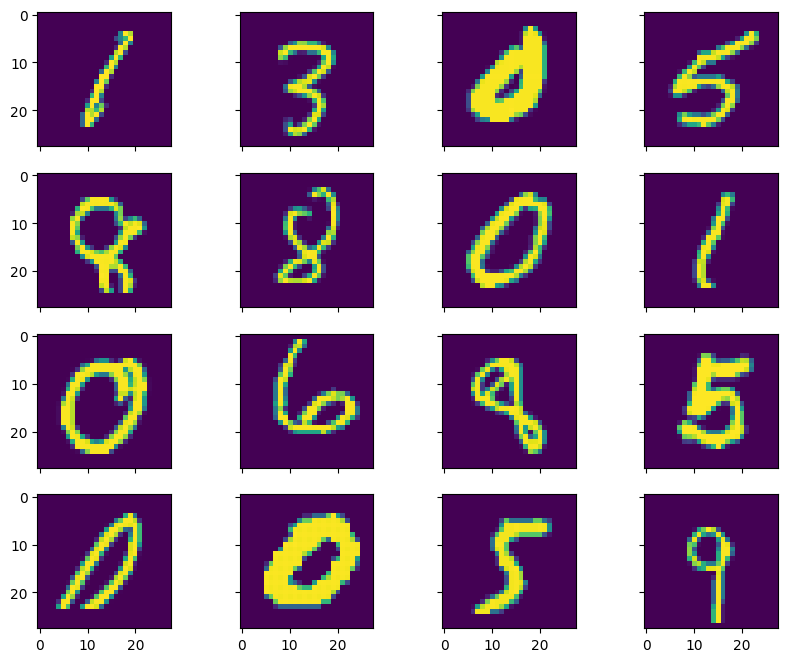

In [37]:
# Lets check few of the dataset
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10, 8))
for images, labels in train_loader:
    for i in range(batch_size):
        row, col = i//4, i%4
        ax[row, col].imshow(images[i].numpy().transpose([1, 2, 0]))
        if i == 15:
            break
plt.show()

In [90]:
# Defining our Model class
class AutoEncoder(nn.Module):
    def __init__(self, n_hidden_1, n_hidden_2, n_encoded, n_input):
        super(AutoEncoder, self).__init__()
        # building the encoder network
        self.encoder = nn.Sequential(
            nn.Linear(n_input, n_hidden_1),
            nn.ReLU(),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(),
            nn.Linear(n_hidden_2, n_encoded),
            nn.ReLU()
        )
        # building the decoder network
        self.decoder = nn.Sequential(
            nn.Linear(n_encoded, n_hidden_2),
            nn.ReLU(),
            nn.Linear(n_hidden_2, n_hidden_1),
            nn.ReLU(),
            nn.Linear(n_hidden_1, n_input),
            nn.Sigmoid()
        )
    # Forward pass of the model will consist of encoding of the data and decoding from that encoded data
    def forward(self, inp):
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded
        

In [91]:
# Cost function is the mean squared loss between the predicted image and the original one
def cost_fn(y_true, y_pred):
    return nn.MSELoss(reduction='mean')(y_pred, y_true)

In [92]:
# train function
def train(train_loader, model, epochs, device, lr):
    ## configure the optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0 # calculate the total loss for one epoch
        for i, (inp, target) in enumerate(train_loader):
            # transfer the data to the same device as the model
            inp = inp.to(device)
            # flattening the input i.e. (28*28). final shape is (batch_size,784) 
            flattened_inp = inp.view(inp.size(0), -1)
            # pass through the model
            decoded = model(flattened_inp)
            # calculate loss
            loss = cost_fn(decoded, flattened_inp)
            # configure the gradients to be zero
            opt.zero_grad()
            # add up the loss
            epoch_loss += loss
            # pass backward to calculate gradients
            loss.backward()
            # update the gradients
            opt.step()
        print(f"epoch {epoch+1}, loss = {epoch_loss}")
            

In [94]:
# initialize input shapes for data, hidden layers, batch size, epochs and learning rate
n_input = 28*28
n_hidden_1 = 512
n_hidden_2 = 256
n_encoding = 32
lr = 0.001
epochs = 10

In [95]:
# initialize the model with specified layer sizes and shapes
model = AutoEncoder(n_hidden_1, n_hidden_2, n_encoding, n_input)
# configure device to do computation in
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# transfer model to device
model.to(device)
# start training the model
train(train_loader, model, epochs, device, lr)


epoch 1, loss = 5.364140033721924
epoch 2, loss = 3.5355236530303955
epoch 3, loss = 2.600984811782837
epoch 4, loss = 2.028336524963379
epoch 5, loss = 1.77799391746521
epoch 6, loss = 1.5683751106262207
epoch 7, loss = 1.4293988943099976
epoch 8, loss = 1.3393242359161377
epoch 9, loss = 1.265433669090271
epoch 10, loss = 1.193158507347107


In [96]:
# Check how the model is performing on unseen data
# fetch one batch from the test data
test_img, _ = next(iter(test_loader))
# send to device, since our model is on the device
test_img = test_img.to(device)
# flatten the image
test_img = test_img.view(test_img.size(0), -1)
# pass through the model once, we will get the decoded values
encode_decode = model(test_img)

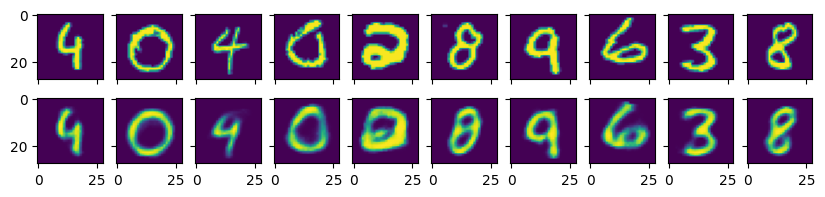

In [97]:
# lets check encoded and decoded images with original images
fig, ax = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(10, 2))
for i in range(10):
    ax[0][i].imshow(np.reshape(test_img[i].cpu().detach().numpy(), (28, 28)))
    ax[1][i].imshow(np.reshape(encode_decode[i].cpu().detach().numpy(), (28, 28)))